In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import*
import aplpy
from matplotlib import*
from astropy.convolution import Kernel1D
from astropy.convolution import Box1DKernel
from astropy import units as u
from astropy.io import fits
from spectral_cube import SpectralCube
from spectral_cube import* # SpectralCube 
#from spectral_cube import Projection 
import scipy.ndimage as nd
from pvextractor import extract_pv_slice
from pvextractor import Path
from scipy import optimize
from sympy import nsolve
from scipy.optimize import fsolve 
from scipy.constants import*
from astropy import constants as con
from astropy import units as u
#import matplotlib.mlab as mlab
from astropy.convolution import Kernel1D
import scipy.ndimage as nd
import aplpy
import matplotlib 
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator
from scipy import stats
from astropy.table import Table
from matplotlib.ticker import FormatStrFormatter
from astropy.wcs import WCS
from astropy.wcs import utils 
from astropy.wcs.utils import pixel_to_skycoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.table import QTable
#from yt.mods import ColorTransferFunction, write_bitmap
#from astropy import yt

In [344]:
####################################################################################################################
########                              INPUT OUTFLOW VALUES                                                ##########
########  CENTRAL COORDIATES, RED AND BLUE LOBE COORDINATES, AND VELOCITY RANGES FROM GAIA SPECTRAL IMAGE ##########
####################################################################################################################

########################### hh mm ss to deg conversion ############################################################
# blue lobe coordiantes in original field 
hh = 20
mm = 20
ss = 38.72
d = 42
m = 2
s = 26.27
ra_b = ((hh+mm/60+ss/3600)*15)*u.deg #360 deg / 24 hrs
dec_b = (d+m/60+s/3600)*u.deg

# red lobe coordiantes in original field 
hh = 20
mm = 20
ss = 37.38#22.416
d = 42
m = 2
s = 25.74#49.56
ra_r = ((hh+mm/60+ss/3600)*15)*u.deg #360 deg / 24 hrs
dec_r = (d+m/60+s/3600)*u.deg

print(ra_b,dec_b,ra_r,dec_r)

305.1613333333333 deg 42.04063055555555 deg 305.15575 deg 42.040483333333334 deg


In [345]:
####################################################################################################################
#####################                                                      ##########################################
#####################       Outflow Coordinates and Velocity               #########################################
#####################                                                      #########################################
####################################################################################################################


################################# COLLECT DATA FOR 12 OUTFLOWS #####################################################
from astropy.table import QTable, Table, Column
from astropy import units as u


t_field = QTable()

tag=['1','2','3','4','5']

t_field['Name'] = tag  

t_field['RAJ2000_blue'] = np.array([305.13583,305.62875,304.50045,304.6059,305.16133])* u.deg   # BLUE PIXEL  deg 
t_field['DecJ2000_blue'] = np.array ([41.41148,41.6061,41.9325,42.03097,42.0406]) * u.deg       # BLUE PIXEL
t_field['RAJ2000_red'] = np.array ([305.1246,305.59875,304.51158,304.5976,305.15575]) * u.deg    # RED PIXEL
t_field['DecJ2000_red'] = np.array ([41.4117,41.59794,41.9204,42.035278,42.04048]) * u.deg        # RED PIXEL
t_field['vbmin'] = np.array ([5,2,-14,-12,-10])*u.km/u.s
t_field['vbmax'] = np.array ([6.5,5,-7,-6,-5.5])*u.km/u.s
t_field['vrmin'] = np.array ([10,6.5,-0.5,-2.5,-2])*u.km/u.s
t_field['vrmax'] = np.array ([20,10,6,5,2.5])*u.km/u.s

distance = 1.5e3  # DISTANCE OF OUTFLOW in kpc # CHANGE HERE #

t_field.write('field13_input.fit', overwrite=True) ### CHANGE FIELD NAME ###

In [346]:
field = QTable.read('field13_input.fit') ### CHANGE FIELD NAME ###
field

Name,RAJ2000_blue,DecJ2000_blue,RAJ2000_red,DecJ2000_red,vbmin,vbmax,vrmin,vrmax
,deg,deg,deg,deg,km / s,km / s,km / s,km / s
bytes1,float64,float64,float64,float64,float64,float64,float64,float64
1,305.13583,41.41148,305.1246,41.4117,5.0,6.5,10.0,20.0
2,305.62875,41.6061,305.59875,41.59794,2.0,5.0,6.5,10.0
3,304.50045,41.9325,304.51158,41.9204,-14.0,-7.0,-0.5,6.0
4,304.6059,42.03097,304.5976,42.035278,-12.0,-6.0,-2.5,5.0
5,305.16133,42.0406,305.15575,42.04048,-10.0,-5.5,-2.0,2.5


In [184]:
pvslice12.shape[1]*a_min

6.187184335382192

In [339]:
co12.max()

/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/spectral_cube.py:416: RuntimeWarning: All-NaN slice encountered
  **kwargs)


<Quantity nan K>

/home/sdeb/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


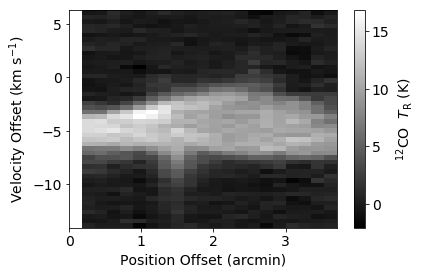

In [323]:
ax3 = fig.add_subplot(gs[1,2:]) 
plt.imshow(pvslice12.data[::-1,:],extent=[xmin, xmax, ymin, ymax],aspect='auto',origin='lower',cmap='gray',
               vmin = min(0,nanmin(pvslice12.data[::-1,:])),vmax = nanmax(pvslice12.data[::-1,:])*1)#
clb = plt.colorbar()
clb.set_label('$^{12}$CO  $T_{\mathrm{R}}$ (K)', labelpad=5, y=.5, rotation=90)
cs = ax3.contour(pvslice12.data[::-1,:],extent=[xmin, xmax, ymin, ymax],colors="white",
                     levels=(np.array([0.1,0.3,0.5,0.7,0.9,1]))*int(nanmax(pvslice12.data[::-1,:])))
plt.ylabel("Velocity Offset (km s$^{-1}$)")
plt.xlabel("Position Offset (arcmin)")
plt.show()

In [348]:
field = QTable.read('field13_input.fit') ### CHANGE FIELD NAME ###

## CREATE EMPTY TABLE FOR OUTPUT MASS, MOMENTUM, ENERGY 
t = QTable(names=('Seq','Mass', 'Momentum', 'Energy'), dtype=('S1','f4','f4','f4'))  

for z in range(0,len(field)): # z number of outflows in the list 
    vbmin = field[z]['vbmin'] # BLUE WING
    vbmax = field[z]['vbmax']
    vrmin = field[z]['vrmin']
    vrmax = field[z]['vrmax'] # RED WING

    ra_b = field[z]['RAJ2000_blue'] 
    dec_b = field[z]['DecJ2000_blue']
    ra_r = field[z]['RAJ2000_red']
    dec_r = field[z]['DecJ2000_red']

    RA = ra_b.value
    Dec = dec_b.value


    cube_12co = SpectralCube.read('field13.fits') ### CHANGE FIELD NAME ###
    #cube_12co = SpectralCube.read('field13smooth.fits') ### CHANGE FIELD NAME ###
    ##### SLICE THE MAIN FIELD TO PRODUCE A SUBCUBE WITH CROPPED SPECTRAL AND SPECIAL AXES 

    _, b, _ = cube_12co.world[0, :, 0]  #extract latitude world coordinates from cube
    _, _, l = cube_12co.world[0, 0, :]  #extract longitude world coordinates from cube

    ##### Spatial boundary includes 50 pixels on each side from blue and red lobes 
    db = np.abs(cube_12co.wcs.celestial.wcs.get_cdelt()[0])*10
    dl = -(cube_12co.wcs.celestial.wcs.get_cdelt()[1])*13

    bmin = Dec-db
    bmax = Dec+db
    lmin = RA-dl
    lmax = RA+dl

    lat_range = [bmin, bmax]*u.deg 
    lon_range = [lmin, lmax]*u.deg

    ##### Spectral boundary includes 15 km/s on each side of the vel range 
    dv = (cube_12co.spectral_axis[1]-cube_12co.spectral_axis[0]).value
    vlo = vbmin-15*u.km/u.s
    vhi = vrmax+15*u.km/u.s

    

    # Create a sub_cube cut to these coordinates
    slab = cube_12co.spectral_slab(vlo, vhi) 
    cube = slab.subcube(xlo=lon_range[0], xhi=lon_range[1], ylo=lat_range[0], yhi=lat_range[1])
    #cube = cube.spectral_slab(vlo, vhi) 


    ###############################################################################################################
    ###################################                             ###############################################
    ###################################  VISUALIZATION OF OUTFLOW   ###############################################
    ###################################                             ###############################################
    ###############################################################################################################

    from astropy.table import QTable
    from astropy import units as u

    ##### FUNCTIONS #############
    def f(pb,pr): # pb = blue lobe pixel. USE A LINEAR FUNCTION JOINING BLUE AND RED LOBE PIXELS
        x0 = (pb[0]+pr[0])/2
        y0 = (pb[1]+pr[1])/2
        m = (pr[1]-pb[1])/(pr[0]-pb[0])
        dx = np.abs(pb[0]-x0)
        xb = x0 - 3*dx
        xr = x0 + 3*dx
        yb = y0 + m*(xb-x0)
        yr = y0 + m*(xr-x0)
        pb2 = (xb,yb)
        pr2 = (xr,yr)
        return pb2, pr2

    ###################################################################################################################
    ### EXTRACT PIXEL COORDINATES FROM WORLD SKY COORDINATES 

    from astropy import wcs
    cdelt = utils.proj_plane_pixel_scales(cube.wcs)
    cdelt
    w = wcs.WCS(cube[0].header)
    pix_coord_b = w.wcs_world2pix(ra_b.value,dec_b.value, 0)
    pix_coord_r = w.wcs_world2pix(ra_r.value,dec_r.value, 0)

    xb = int(round(float(pix_coord_b[0]),0))
    yb = int(round(float(pix_coord_b[1]),0))
    xr = int(round(float(pix_coord_r[0]),0) )     
    yr = int(round(float(pix_coord_r[1]),0))
   
    ####################################################################################################################
    ##################################         SPECTRAL BIPOLARITY            ##########################################
    ####################################################################################################################

    co12 = cube 

    mb = co12[:,(yb-2):(yb+2),(xb-2):(xb+2)].filled_data[:] 
    mr = co12[:,(yr-2):(yr+2),(xr-2):(xr+2)].filled_data[:]


    fig = plt.figure(figsize=(12,10),constrained_layout=True)
    matplotlib.rcParams.update({'font.size': 14})

    gs = gridspec.GridSpec(nrows=2, ncols=4, figure=fig)

    ax1 = fig.add_subplot(gs[:, 0:2])
    #plt.plot(co12.spectral_axis, mb.mean(axis=(1,2)).value/1, color='blue')
    #plt.plot(co12.spectral_axis, mr.mean(axis=(1,2)).value/1.0,color='red') 
    plt.plot(co12.spectral_axis, nanmean(mb,axis=(1,2)).value/1.0,color='blue')
    plt.plot(co12.spectral_axis, nanmean(mr,axis=(1,2)).value/1.0,color='red')
    plt.xlabel("$v_{\mathrm{LSR}}$ (km s$^{-1}$)")
    plt.ylabel("Intensity (K)")

    plt.axvline(x=vbmin.value,color='b',linestyle='--') 
    plt.axvline(x=vbmax.value,color='b',linestyle='--')
    plt.axvline(x=vrmin.value,color='r',linestyle='--')
    plt.axvline(x=vrmax.value,color='r',linestyle='--')

    plt.axhline(y=0,color='k',linestyle='--')
    
    xminvalue = co12.spectral_axis.min().value
    xmaxvalue = co12.spectral_axis.max().value
    plt.xlim(left=xminvalue)
    plt.xlim(right=xmaxvalue)
    plt.ylim(bottom=-5)
    
    ymaxvalue = nanmax([nanmax(nanmean(mb,axis=(1,2))).value,nanmax(nanmean(mr,axis=(1,2))).value])+10
    if ymaxvalue == NaN:
        yvalue = 20
    else:
        yvalue = ymaxvalue 
    plt.ylim(top=20)

    plt.axvspan(vbmin.value,vbmax.value,ymin=0,ymax=1,alpha=0.1, color='b')#ymin, ymax are in terms of %age of height to be covered 
    plt.axvspan(vrmin.value, vrmax.value,alpha=0.1, color='r')
    ax1.set_title('(a)')

    ####################################################################################################################
    ##################################                 CONTOUR                ##########################################
    ####################################################################################################################

    slab_blue=co12.spectral_slab(vbmin, vbmax) #contour
    slab_red = co12.spectral_slab(vrmin, vrmax) ######## CHANGE HERE #########
    slab_main = co12.spectral_slab(vbmin, vrmax) 

    mom0_main =slab_main.moment(order=0)
    mom0_blue =slab_blue.moment(order=0)
    mom0_red =slab_red.moment(order=0)
    
    #mom0_main = nanmean(slab_main,axis=0)
    #mom0_blue = nanmean(slab_blue,axis=0)
    #mom0_red = nanmean(slab_red,axis=0)

    matplotlib.rcParams.update({'font.size': 13})

    ax2 = fig.add_subplot(gs[0,2:],projection=cube[0].wcs)
    im1=ax2.imshow((mom0_main.value),interpolation='nearest',label='$^{12}CO$',
                  origin='lower', cmap='gray',vmin=nanmin(mom0_main).value,vmax=nanmax(mom0_main).value)
    clb=plt.colorbar(im1)
    ax2.set_ylabel("Dec (J2000)")
    ax2.set_xlabel("RA (J2000)")
    ax2.set_autoscale_on(False)

    lat = ax2.coords[0]
    lat.set_major_formatter('hh:mm:ss')
    lon = ax2.coords[1]
    lon.set_major_formatter('dd:mm')


    clb.set_label('$^{12}$CO Integrated Intensity (K km s$^{-1}$)', labelpad=5, y=.5, rotation=90)
    cs = ax2.contour(mom0_blue.value,colors="blue",levels=(np.array([0.25,0.5,0.75,1]))*int(nanmax(mom0_blue).value))
    cs = ax2.contour(mom0_red.value,colors="red",levels=(np.array([0.25,0.5,0.75,1]))*int(nanmax(mom0_red).value))
    ax2.set_title('(b)')

    ########################################################################################################
    ##################################                  PV-SLICE              ##############################
    ########################################################################################################
    matplotlib.rcParams.update({'font.size': 13})

    ##################################################################################################
    # 1. create pv-slice (crop both spatial and spectral axes)

    pb = (xb,yb) # BLUE LOBE CENTER PIXEL 
    pr = (xr,yr) # RED LOBE CENTER PIXEL

    ## create two extended points (pixels) along the pv line 
    xbl = f(pb,pr)[0][0]
    ybl = f(pb,pr)[0][1]
    xrh = f(pb,pr)[1][0]
    yrh = f(pb,pr)[1][1]


    width = 1
    path = Path([(xbl, ybl), (xrh, yrh)], width=1) 
    slab=co12.spectral_slab(vbmin, vrmax) # range from spectral bipolar plot
    vslabmin = slab.spectral_extrema[0]
    pvslice12 = extract_pv_slice(slab, path)


    #############################################################################################
    # 2. CREATE X AND Y TICK LABELS IN POSITION AND VELOCITY VALUES 

    a_deg = (2*(cube.wcs.celestial.wcs.get_cdelt()[0])**2)**.5
    a_min = a_deg*60
    xmin = 0
    xmax = pvslice12.shape[1]*a_min # shape of spetial axis * spatial resolution in arcmin
    ticks_x = np.linspace(0,xmax,6)
    ticklabels_x = ["{:3.1f}".format(i) for i in (ticks_x)]

    dv_12co = (cube_12co.spectral_axis[1]-cube_12co.spectral_axis[0]).value #spectral axis resolution of 12co raw data 
    ymin = vslabmin.value # min velocity km/s obtained from spectral bipolar plot ###### CHANGE HERE ######
    ymax = pvslice12.shape[0]*dv_12co + ymin # shape of spectral axis * vel resolution in km/s
    ticks_y = np.linspace(ymax, ymin, 6) # show 8 (arbitrary) y ticks
    ticklabels_y = ["{:3.0f}".format(i) for i in (ticks_y)]

    ############################################################################################################
    # 3. PLOT
    ax3 = fig.add_subplot(gs[1,2:]) 
    plt.imshow(pvslice12.data[::-1,:],extent=[xmin, xmax, ymin, ymax],aspect='auto',origin='lower',cmap='gray',
               vmin = min(0,nanmin(pvslice12.data[::-1,:])),vmax = nanmax(pvslice12.data[::-1,:])*1)#
    clb = plt.colorbar()
    clb.set_label('$^{12}$CO  $T_{\mathrm{R}}$ (K)', labelpad=5, y=.5, rotation=90)
    cs = ax3.contour(pvslice12.data[::-1,:],extent=[xmin, xmax, ymin, ymax],colors="white",
                     levels=(np.array([0.1,0.3,0.5,0.7,0.9,1]))*int(nanmax(pvslice12.data[::-1,:])))
    plt.ylabel("Velocity Offset (km s$^{-1}$)")
    plt.xlabel("Position Offset (arcmin)")
    ax3.set_title('(c)')

    plt.savefig(str(z+1),format='pdf',bbox_inches = 'tight', dpi=300,overwrite=True)
    plt.close()
    print('success_plots')
    
    ####################################################################################################################
    #######################                                                   ##########################################
    #######################           13CO MASS FROM 12CO DATA                ##########################################
    #######################                                                   ##########################################
    ####################################################################################################################

    ### DEFINE FUNCTIONS 

    def length(s):
        if s%2 == 0: #modulo zero => even
            l = s/2
        else:
            l = (s+1)/2
        return l

    def Jnu(T, nu=330.5*u.GHz):
        jnu = ((con.h * nu / con.k_B)
               / (np.exp(con.h * nu / (con.k_B * T)) - 1))
        return( jnu )

    def G(v, Amp, V0, Sig0, Offset):
        return( Amp * np.exp(-(v-V0)**2/(2*Sig0**2))+Offset )

    def Quad(v, c0, v0, c2):
        return( c0 + c2 * (v - v0)**2 ) # a + b(x-x0)^2 form
    # Read in data

    co12 = cube
    vaxis = co12.spectral_axis.value

    # Width of PV slice based on beamsize # check header file #
    from astropy.wcs import utils 
    ang_width = 1 * 14.6 * u.arcsec
    cdelt = utils.proj_plane_pixel_scales(co12.wcs)
    width = (ang_width / (cdelt[0] * u.deg)).to(u.dimensionless_unscaled).value

    # Extract matched PV slices
    path = Path([(xb, yb), (xr, yr)], width=1)
    slice12 = extract_pv_slice(co12, path)
    slicewt = extract_pv_slice(np.ones(co12.shape), path)
    slcshape = slice12.data.shape

    v0array = np.zeros(slice12.data.shape[1])
    sig0array = np.zeros(slice12.data.shape[1])
    amparray= np.zeros(slice12.data.shape[1])

    # Now calculate the opacitypoptblue, pcov = optimize.curve_fit(Quad, vaxis[EndFitBlue:StartFitBlue],(blue12 / blue13)[EndFitBlue:StartFitBlue],p0 = (c0, v0, c2),maxfev = 1000000)
    Tpeak = np.max(slice12.data)
    nu = 330.588 * u.GHz
    Tbg = 2.73 * u.K
    Aul = 6.038e-7 / u.s
    B0 = 54891.42 * u.MHz
    E3 = 30 * u.K
    Tex = ((con.h * nu / con.k_B)
           / np.log(1 + con.h * nu
                    / (con.k_B * (Tpeak * u.K + Jnu(Tbg, nu=nu)))))
    Tex = Tex.to(u.K)

    co13slice = np.zeros_like(slice12.data)

    DeltaNu = np.abs((vaxis[1] - vaxis[0]) * u.km / u.s/ con.c * nu).to(u.Hz)
    DeltaNu = np.abs((vaxis[1] - vaxis[0]) * u.km/u.s)

    log_co13slice = 2.074571 * np.log10(slice12.data) - 2.699635
    co13slice=10**log_co13slice

    tau13dnu = co13slice * DeltaNu 

    N13co = (8 * np.pi * nu**3 / con.c**3 / Aul
             /(np.exp(con.h * nu / con.k_B / Tex) - 1) * tau13dnu
             )
    Qrot = con.k_B * Tex / (con.h * B0) * np.exp(con.h * B0
                                                 / (3 * con.k_B * Tex))
    # Calculate column density of material
    N13coTot = Qrot / 7 * np.exp(E3 / Tex) * N13co # g_u=7 for u=3, l=2 transition
    # Assume a column density ratio
    NH2 = (7.5e5 * N13coTot).to(u.cm**(-2))

    apix = np.prod(
        np.abs(np.array([width, 1]) 
               * (co12.wcs.celestial.wcs.get_cdelt())
            / 180 * np.pi * distance)) * u.pc**2
    Mass12 = (NH2 * con.m_n * 2.32 * apix).to(u.solMass)

    ############################################ sigma calculation #####################################################
    slcshape=slice12.data.shape 
    Tpeak=np.ones(slcshape[1])
    vpeak=np.ones(slcshape[1])
    sigma12=np.ones(slcshape[1])
    vaxis=co12.spectral_axis.value
    for i in range(slcshape[1]):
            spec=slice12.data[:,i]
            Tpeak[i]=np.nanmax(spec)
            vpeak[i]=vaxis[np.nanargmax(spec)]
            hf=Tpeak[i]/2
            #plt.plot(vaxis,spec)
            #plt.axvline(x=vpeak[i],color='r',linestyle='--')
            #plt.axhline(y=hf,color='k')
            #plt.show()
            vraw=vaxis[spec>=hf] # vraw may be completely to the left or right on vpeak value, ideally on both sides
            #print('vpeak:',vpeak[i])
            #print('vraw:',vraw)
            vp=vraw[vraw>=vpeak[i]]
            #print('vp:',vp)
            vn=vraw[vraw<=vpeak[i]]
            #print('vn:',vn)
            vp_max=np.max(vp)
            vn_max=np.min(vn)
            if np.abs(vp_max-vpeak[i]) == 0:  # This condition makes sure sigma is not zero
                HWHM = np.abs(vn_max-vpeak[i])
            elif np.abs(vn_max-vpeak[i]) == 0:
                HWHM = np.abs(vp_max-vpeak[i])
            else:
                HWHM=np.minimum(np.abs(vp_max-vpeak[i]),np.abs(vn_max-vpeak[i]))
            sigma12[i]=HWHM/((2*np.log(2))**0.5)

    ################################ MINIMIZATION OF ENERGY BASED ON H2 MASS (PROJECTED 13CO) ######################
    #### energy of the entire spectrum under the spectrum profile for each pixel wrt Tpeak velocity
    #### This finds the line center at which E=minfor each position
    from astropy import units as u
    N=int(slcshape[0]/2) #this integer must be less than spectral pixel number
    Energy=np.zeros(N)
    vcen=np.zeros(shape=(slcshape[1],N)) # this number must be less than spectral pixel number
    vcentr=np.zeros(slcshape[1]) # dim should be equal to the number of spatial pixels along the mass pv slice

    for i in range(slcshape[1]):
        l=vpeak[i]-5*sigma12[i]
        u=vpeak[i]+5*sigma12[i]
        vcen[i,:]=np.linspace(l,u,N) # half of spectral pixels     
    
    for i in range(slcshape[1]):
        spec=slice12.data[:,i]
        vpeak[i]=vaxis[np.nanargmax(spec)]
        for j in range(N):
            voff=vaxis-vcen[i,j]#*u.km**2/u.s**2
            Energy[j]=(np.nansum(Mass12[:,i].value*voff**2))#.to(u.erg)#SUM OVER 1445 VEL VALUES
        voff_argmin=voff[np.nanargmin(Energy)]
        vcentr[i]=vcen[i,:][np.nanargmin(Energy)]#*u.km/u.s#finds vcen_value(among 1e3 vcen values)at which E=min
        

    ############## MASS OF THE RED AND BLUE WINGS BASED OF ONLY 12CO DATA ##############################################
    # fit a gaussian with mean=vcentr and var=sigma12^2 to 12CO data
    # For wing mass calculate mass beyond 3 sigma limit on either side

    ####################################### WING MASS CALCULATION ##################################################
    from astropy import units as u
    co12noise=cube 
    co12noise_bslab=co12.spectral_slab(vbmin-10*u.km/u.s, vbmin-5*u.km/u.s)
    #print('test1:',vbmin-10*u.km/u.s, vbmin-5*u.km/u.s) #test1
    co12noise_rslab=co12.spectral_slab(vrmax+5*u.km/u.s, vrmax+8*u.km/u.s)
    #print('test2:',vrmax+5*u.km/u.s, vrmax+10*u.km/u.s)
    rms12bnoise = np.nanstd(np.array(co12noise_bslab)) # noise from the blue wing side of the spectrum 
    rms12rnoise = np.nanstd(np.array(co12noise_rslab)) # noise from the red wing side of the spectrum 
    rms12noise = np.nanmean([rms12bnoise,rms12rnoise]) ## if noise is NaN Blue/Red counter=0 => symm pixels #

    #print(co12noise_slab.shape[0],rms12noise)
    momentum = np.zeros(slice12.data.shape[1])
    energy = np.zeros(slice12.data.shape[1])
    massvec = np.zeros(slice12.data.shape[1])
    vrange = np.zeros(slcshape[1]) ### OF velocity defined
    for i in range(slcshape[1]):
        voff = vcentr[i]-vaxis
        spec=slice12.data[:,i]
        zl=np.zeros(10)
        zr=np.zeros(10)
        Blue=0
        Red=0
        for j in range(10):
            zl=np.nanargmin(np.abs(vaxis - (vcentr[i]-(1.5+0.3*j)*sigma12[i])))#identify spectral axis pixel at mu-2*sigma
            zr=np.nanargmin(np.abs(vaxis - (vcentr[i]+(1.5+0.3*j)*sigma12[i])))
            spec_left=spec[zl] #emission at mu-multiple of sigma
            spec_right=spec[zr]#identify emission at mu+multiple of sigma 
            if np.abs(spec_left-spec_right)>1*rms12noise: # check if the emission diff is not just noise fluctuation
                            #print('test3:',spec_left-spec_right,rms12noise)
                            if spec_left > spec_right:
                                    Blue=Blue+1
                            elif spec_left < spec_right:
                                   Red=Red+1
                            else: #when mu-sigma and mu+sigma have same emission value don't increase the counter
                                    Blue=Blue
                                    Red=Red
            else:#when emission diff is below noise fluctuation 
                            #print('test4:',spec_left-spec_right,rms12noise)
                            pass
        #print(Blue,Red)
        if Blue >= 3:#then this spatial pixel contains blueshifted wing
            zl = np.nanargmin(np.abs(vaxis - (vcentr[i]-2*sigma12[i])))#identify spectral axis pixel at mu-2*sigma
            spec_left=spec[zl] #emission array at velocity-pixels to the left of mu-2*sigma pixel                 
            v_left= vaxis[zl] #spectral axis value at mu-2*sigma) 
            idx = (vaxis < v_left) & (vaxis > vbmin.value) ## CHANGE
            massvec[i] = np.nansum(Mass12[idx, i]).to(u.M_sun).value
            momentum[i] = np.nansum(Mass12[idx, i] * np.abs(voff[idx])).to(u.M_sun).value
            energy[i] = 0.5 * np.nansum(Mass12[idx, i] * voff[idx]**2).to(u.M_sun).value
            idx_l=(vaxis <=vcentr[i]) ####################### outflow velocity ##########################
            l=(vaxis[idx_l]).shape
            for k in range(slcshape[0]-l[0],slcshape[0]):
                if spec[k]<=rms12noise:
                    #print(k,spec[k],rms12noise)
                    vrange[i]=np.abs(vaxis[k]-vcentr[i])
                    break
            #print('length=',vrange[i]) ###################################################################
        elif Red >= 3:#this pixel contains red shifted wing 
            zr=np.nanargmin(np.abs(vaxis - (vcentr[i]+2*sigma12[i])))#uniquely identify mu+2*sigma velocity-pixel
            v_right=vaxis[zr]
            idx = (vaxis > v_right) & (vaxis < vrmax.value) ## CHANGE
            massvec[i] = np.nansum(Mass12[idx, i]).to(u.M_sun).value
            momentum[i] = np.nansum(Mass12[idx, i] * np.abs(voff[idx])).to(u.M_sun).value
            energy[i] = 0.5 * np.nansum(Mass12[idx, i] * voff[idx]**2).to(u.M_sun).value
            idx_r=(vaxis >= vcentr[i])####################### outflow velocity ##########################
            r=(vaxis[idx_r]).shape
            for k in range(r[0],0,-1):
                #print(k,spec[k])
                if spec[k]<=rms12noise:
                    vrange[i]=np.abs(vaxis[k]-vcentr[i])
                    break
        else:
            #print('symmetrical pixel')
            pass   
    print('Outflow mass=',massvec.sum()*u.solMass)
    print('Outflow momemtum=',momentum.sum()*u.solMass*u.km/u.s)
    print('Outflow energy=',(energy.sum()*u.solMass*u.km**2/u.s**2).to(u.erg))
    mass = massvec.sum()*u.solMass
    mom = momentum.sum()*u.solMass*u.km/u.s
    en = (energy.sum()*u.solMass*u.km**2/u.s**2).to(u.erg)/(1e44*u.erg)
    #print(z+1)
    #print(mass,mom,en)
    t.add_row([z+1,mass.value, mom.value, en.value])
    

t['Mass'].unit = u.solMass
t['Momentum'].unit = u.solMass*u.km/u.s
t['Energy'].unit = 1e44*u.erg

t.write('field13_output.fit',overwrite=True) ### CHANGE NAME ###

Set OBSGEO-B to    19.822832 from OBSGEO-[XYZ].
Set OBSGEO-H to     4117.025 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/spectral_cube.py:246: UserWarning: Could not parse beam information from header.  Exception was: NoBeamException('No BMAJ found and does not appear to be a CASA/AIPS header.',)
  "  Exception was: {0}".format(ex.__repr__()))
/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/spectral_cube.py:1891: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  inds = [i[view] for i in inds[::-1]]  # numpy -> wcs order
/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/masks.py:506: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple


success_plots




/home/sdeb/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:296: RuntimeWarning: invalid value encountered in log10
/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/spectral_cube.py:246: UserWarning: Could not parse beam information from header.  Exception was: NoBeamException('No BMAJ found and does not appear to be a CASA/AIPS header.',)
  "  Exception was: {0}".format(ex.__repr__()))
Set OBSGEO-B to    19.822832 from OBSGEO-[XYZ].
Set OBSGEO-H to     4117.025 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Outflow mass= 0.715888987190216 solMass
Outflow momemtum= 1.1617490677959674 km solMass / s
Outflow energy= 2.0033272534220425e+43 erg


/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/spectral_cube.py:1891: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  inds = [i[view] for i in inds[::-1]]  # numpy -> wcs order
/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/masks.py:506: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return LazyMask(self._function, data=self._data[view],
/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/spectral_cube.py:1080: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us


success_plots




/home/sdeb/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:296: RuntimeWarning: invalid value encountered in log10
/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/spectral_cube.py:246: UserWarning: Could not parse beam information from header.  Exception was: NoBeamException('No BMAJ found and does not appear to be a CASA/AIPS header.',)
  "  Exception was: {0}".format(ex.__repr__()))
Set OBSGEO-B to    19.822832 from OBSGEO-[XYZ].
Set OBSGEO-H to     4117.025 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Outflow mass= 0.04350829597314562 solMass
Outflow momemtum= 0.07714113711800155 km solMass / s
Outflow energy= 1.612515725073468e+42 erg


/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/spectral_cube.py:1891: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  inds = [i[view] for i in inds[::-1]]  # numpy -> wcs order
/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/masks.py:506: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return LazyMask(self._function, data=self._data[view],
/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/spectral_cube.py:1080: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us


success_plots




/home/sdeb/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:296: RuntimeWarning: invalid value encountered in log10
/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/spectral_cube.py:246: UserWarning: Could not parse beam information from header.  Exception was: NoBeamException('No BMAJ found and does not appear to be a CASA/AIPS header.',)
  "  Exception was: {0}".format(ex.__repr__()))
Set OBSGEO-B to    19.822832 from OBSGEO-[XYZ].
Set OBSGEO-H to     4117.025 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Outflow mass= 2.5417548421817022 solMass
Outflow momemtum= 5.684772443778871 km solMass / s
Outflow energy= 1.4809183062341012e+44 erg


/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/spectral_cube.py:1891: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  inds = [i[view] for i in inds[::-1]]  # numpy -> wcs order
/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/masks.py:506: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return LazyMask(self._function, data=self._data[view],
/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/spectral_cube.py:1080: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us


success_plots




/home/sdeb/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:296: RuntimeWarning: invalid value encountered in log10
/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/spectral_cube.py:246: UserWarning: Could not parse beam information from header.  Exception was: NoBeamException('No BMAJ found and does not appear to be a CASA/AIPS header.',)
  "  Exception was: {0}".format(ex.__repr__()))
Set OBSGEO-B to    19.822832 from OBSGEO-[XYZ].
Set OBSGEO-H to     4117.025 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Outflow mass= 0.4659264109668292 solMass
Outflow momemtum= 1.1864989770967034 km solMass / s
Outflow energy= 3.3411060915034225e+43 erg


/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/spectral_cube.py:1891: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  inds = [i[view] for i in inds[::-1]]  # numpy -> wcs order
/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/masks.py:506: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return LazyMask(self._function, data=self._data[view],
/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/spectral_cube.py:1080: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us


success_plots




/home/sdeb/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:296: RuntimeWarning: invalid value encountered in log10
/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/spectral_cube.py:246: UserWarning: Could not parse beam information from header.  Exception was: NoBeamException('No BMAJ found and does not appear to be a CASA/AIPS header.',)
  "  Exception was: {0}".format(ex.__repr__()))
Set OBSGEO-B to    19.822832 from OBSGEO-[XYZ].
Set OBSGEO-H to     4117.025 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Outflow mass= 0.372223951737429 solMass
Outflow momemtum= 0.7408774524918935 km solMass / s
Outflow energy= 1.5196200995170306e+43 erg


/home/sdeb/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice
/home/sdeb/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: Mean of empty slice


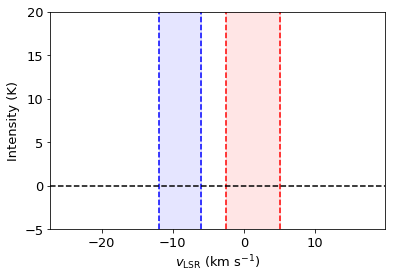

In [337]:

    #plt.plot(co12.spectral_axis, mb.mean(axis=(1,2)).value/1, color='blue')
    #plt.plot(co12.spectral_axis, mr.mean(axis=(1,2)).value/1.0,color='red') 
plt.plot(co12.spectral_axis, nanmean(mb,axis=(1,2)).value/1.0,color='blue')
plt.plot(co12.spectral_axis, nanmean(mr,axis=(1,2)).value/1.0,color='red')
plt.xlabel("$v_{\mathrm{LSR}}$ (km s$^{-1}$)")
plt.ylabel("Intensity (K)")

plt.axvline(x=vbmin.value,color='b',linestyle='--') 
plt.axvline(x=vbmax.value,color='b',linestyle='--')
plt.axvline(x=vrmin.value,color='r',linestyle='--')
plt.axvline(x=vrmax.value,color='r',linestyle='--')

plt.axhline(y=0,color='k',linestyle='--')
    
xminvalue = co12.spectral_axis.min().value
xmaxvalue = co12.spectral_axis.max().value
plt.xlim(left=xminvalue)
plt.xlim(right=xmaxvalue)
plt.ylim(bottom=-5)

plt.ylim(top=20)

plt.axvspan(vbmin.value,vbmax.value,ymin=0,ymax=1,alpha=0.1, color='b')#ymin, ymax are in terms of %age of height to be covered 
plt.axvspan(vrmin.value, vrmax.value,alpha=0.1, color='r')
plt.show()

In [309]:
field13 = QTable.read('field13_output.fit') ### CHANGE FIELD NAME ###
field13

Seq,Mass,Momentum,Energy
,solMass,km solMass / s,1e+44 erg
bytes1,float32,float32,float32
1,0.7158889770507812,1.1617491245269775,0.20033273100852966
2,0.043508294969797134,0.07714113593101501,0.016125157475471497
3,2.541754961013794,5.684772491455078,1.480918288230896


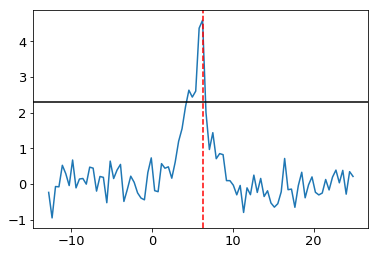

vpeak: 6.246842054022447
vraw: [4.55349219 4.97682966 5.40016712 5.82350459 6.24684205]
vp: [6.24684205]
vn: [4.55349219 4.97682966 5.40016712 5.82350459 6.24684205]


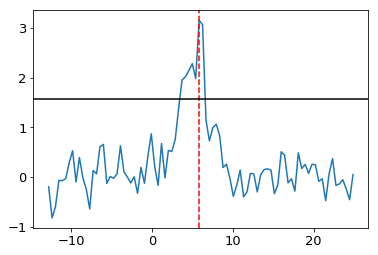

vpeak: 5.823504588054144
vraw: [3.70681726 4.13015472 4.55349219 4.97682966 5.40016712 5.82350459
 6.24684205]
vp: [5.82350459 6.24684205]
vn: [3.70681726 4.13015472 4.55349219 4.97682966 5.40016712 5.82350459]


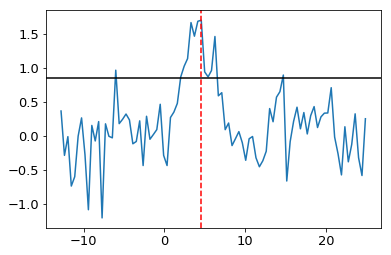

vpeak: 4.553492190149227
vraw: [-6.02994446  2.01346739  2.43680486  2.86014233  3.28347979  3.70681726
  4.13015472  4.55349219  4.97682966  5.40016712  5.82350459  6.24684205
 14.71359137]
vp: [ 4.55349219  4.97682966  5.40016712  5.82350459  6.24684205 14.71359137]
vn: [-6.02994446  2.01346739  2.43680486  2.86014233  3.28347979  3.70681726
  4.13015472  4.55349219]


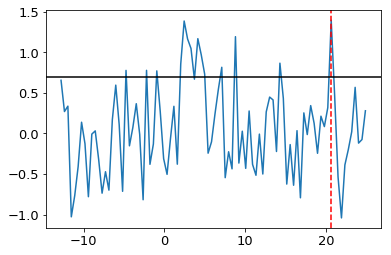

vpeak: 20.64031589694482
vraw: [-4.75993206 -2.21990727 -0.94989487  2.01346739  2.43680486  2.86014233
  3.28347979  4.13015472  4.55349219  4.97682966  7.09351699  8.78686685
 14.29025391 20.6403159 ]
vp: [20.6403159]
vn: [-4.75993206 -2.21990727 -0.94989487  2.01346739  2.43680486  2.86014233
  3.28347979  4.13015472  4.55349219  4.97682966  7.09351699  8.78686685
 14.29025391 20.6403159 ]


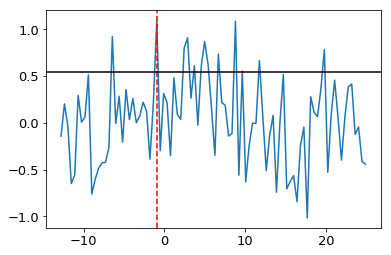

vpeak: -0.9498948674387357
vraw: [-6.45328193 -0.94989487  2.43680486  2.86014233  3.70681726  4.55349219
  4.97682966  5.40016712  6.67017952  8.78686685  9.63354178 11.75022911
 19.79364097]
vp: [-0.94989487  2.43680486  2.86014233  3.70681726  4.55349219  4.97682966
  5.40016712  6.67017952  8.78686685  9.63354178 11.75022911 19.79364097]
vn: [-6.45328193 -0.94989487]


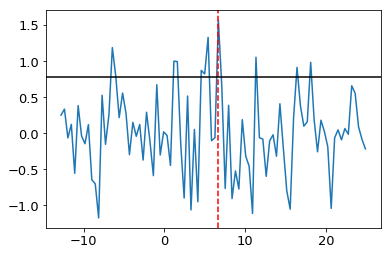

vpeak: 6.670179519990757
vraw: [-6.45328193 -6.02994446  1.16679246  1.59012993  4.55349219  4.97682966
  5.40016712  6.67017952 11.32689165 16.40694124 18.1002911 ]
vp: [ 6.67017952 11.32689165 16.40694124 18.1002911 ]
vn: [-6.45328193 -6.02994446  1.16679246  1.59012993  4.55349219  4.97682966
  5.40016712  6.67017952]


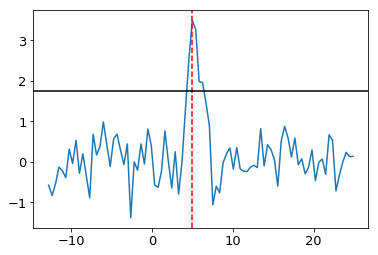

vpeak: 4.976829656117538
vraw: [4.55349219 4.97682966 5.40016712 5.82350459 6.24684205]
vp: [4.97682966 5.40016712 5.82350459 6.24684205]
vn: [4.55349219 4.97682966]


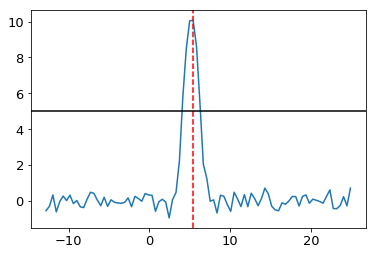

vpeak: 5.400167122085841
vraw: [4.13015472 4.55349219 4.97682966 5.40016712 5.82350459 6.24684205]
vp: [5.40016712 5.82350459 6.24684205]
vn: [4.13015472 4.55349219 4.97682966 5.40016712]


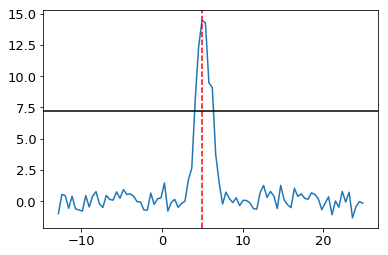

vpeak: 4.976829656117538
vraw: [4.13015472 4.55349219 4.97682966 5.40016712 5.82350459 6.24684205]
vp: [4.97682966 5.40016712 5.82350459 6.24684205]
vn: [4.13015472 4.55349219 4.97682966]


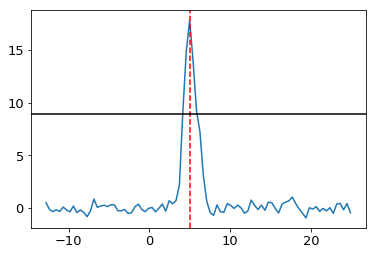

vpeak: 4.976829656117538
vraw: [4.13015472 4.55349219 4.97682966 5.40016712 5.82350459]
vp: [4.97682966 5.40016712 5.82350459]
vn: [4.13015472 4.55349219 4.97682966]


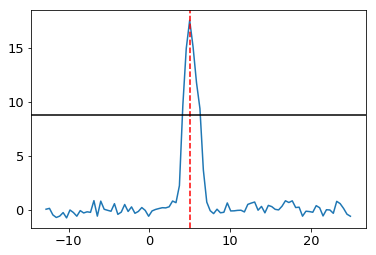

vpeak: 4.976829656117538
vraw: [4.13015472 4.55349219 4.97682966 5.40016712 5.82350459 6.24684205]
vp: [4.97682966 5.40016712 5.82350459 6.24684205]
vn: [4.13015472 4.55349219 4.97682966]
test sigma: [ 1.43819895  0.35954974  8.62919373 21.57298432  4.6741466   9.70784295
  0.35954974  0.71909948  0.71909948  0.71909948  0.71909948]


In [277]:
slcshape=slice12.data.shape
Tpeak=np.ones(slcshape[1])
vpeak=np.ones(slcshape[1])
sigma12=np.ones(slcshape[1])
vaxis=co12.spectral_axis.value
for i in range(slcshape[1]):
        spec=slice12.data[:,i]
        Tpeak[i]=np.nanmax(spec)
        vpeak[i]=vaxis[np.nanargmax(spec)]
        hf=Tpeak[i]/2
        plt.plot(vaxis,spec)
        plt.axvline(x=vpeak[i],color='r',linestyle='--')
        plt.axhline(y=hf,color='k')
        plt.show()
        vraw=vaxis[spec>=hf] # vraw may be completely to the left or right on vpeak value, ideally on both sides
        print('vpeak:',vpeak[i])
        print('vraw:',vraw)
        vp=vraw[vraw>=vpeak[i]]
        print('vp:',vp)
        vn=vraw[vraw<=vpeak[i]]
        print('vn:',vn)
        vp_max=np.max(vp)
        vn_max=np.min(vn)
        if np.abs(vp_max-vpeak[i]) == 0:  # This condition makes sure sigma is not zero
            HWHM = np.abs(vn_max-vpeak[i])
        elif np.abs(vn_max-vpeak[i]) == 0:
            HWHM = np.abs(vp_max-vpeak[i])
        else:
            HWHM=np.minimum(np.abs(vp_max-vpeak[i]),np.abs(vn_max-vpeak[i]))
        sigma12[i]=HWHM/((2*np.log(2))**0.5)
        
print('test sigma:',sigma12)

In [246]:
Tpeak.shape,vpeak.shape

((11,), (11,))

Set OBSGEO-B to    19.822832 from OBSGEO-[XYZ].
Set OBSGEO-H to     4117.025 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/spectral_cube.py:246: UserWarning: Could not parse beam information from header.  Exception was: NoBeamException('No BMAJ found and does not appear to be a CASA/AIPS header.',)
  "  Exception was: {0}".format(ex.__repr__()))


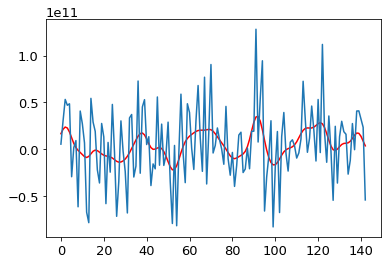

In [174]:
########################################### SMOOTHING ##############################################################

############### DIRECT SMMOTHING OF 12CO USING A GIVEN RESOLUTION  FULL-WIDTH = RATIO ##############################

cube = SpectralCube.read('field13.fits')
vleft = -30*u.km/u.s
vright = 30*u.km/u.s
cube = cube.spectral_slab(vleft,vright) 
dv_12co= cube.spectral_axis[1]-cube.spectral_axis[0]#spectral axis resolution of 12co raw data 
dv_13co=0.055355*u.km/u.s
fw=(2.5)
#fw = np.sqrt(8*np.log(2))
kernel=Box1DKernel(fw)
kernel = Gaussian1DKernel(2.5)

new_cube=cube.spectral_smooth(kernel)
plt.plot(new_cube.mean(axis=(1,2)).value+0.2,'red')
plt.plot(cube.mean(axis=(1,2)).value)
plt.show()




Set OBSGEO-B to    19.822832 from OBSGEO-[XYZ].
Set OBSGEO-H to     4117.025 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


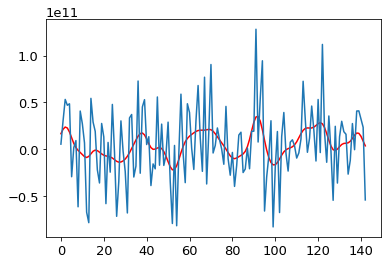

In [175]:
#new_cube=cube.spectral_smooth(kernel)
plt.plot(new_cube.mean(axis=(1,2)).value+0.2,'red')
plt.plot(cube.mean(axis=(1,2)).value)
plt.show()

new_cube.write('field13smoothG.fits',overwrite=True)

Set OBSGEO-B to    19.822919 from OBSGEO-[XYZ].
Set OBSGEO-H to     4117.025 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/spectral_cube.py:246: UserWarning: Could not parse beam information from header.  Exception was: NoBeamException('No BMAJ found and does not appear to be a CASA/AIPS header.',)
  "  Exception was: {0}".format(ex.__repr__()))


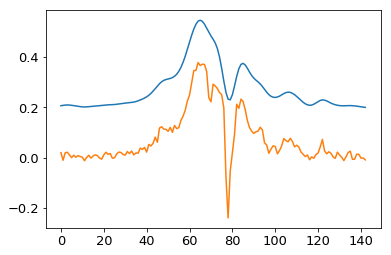

In [157]:
from astropy.convolution import Gaussian1DKernel

cube = SpectralCube.read('field09.fits')
vleft = -30*u.km/u.s
vright = 30*u.km/u.s
cube = cube.spectral_slab(vleft,vright)
kernel = Gaussian1DKernel(2.5)
new_cube = cube.spectral_smooth(kernel)

plt.plot(new_cube.mean(axis=(1,2)).value+0.2)
plt.plot(cube.mean(axis=(1,2)).value)
plt.show()

Set OBSGEO-B to    19.822919 from OBSGEO-[XYZ].
Set OBSGEO-H to     4117.025 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/home/sdeb/anaconda3/lib/python3.5/site-packages/spectral_cube/spectral_cube.py:246: UserWarning: Could not parse beam information from header.  Exception was: NoBeamException('No BMAJ found and does not appear to be a CASA/AIPS header.',)
  "  Exception was: {0}".format(ex.__repr__()))


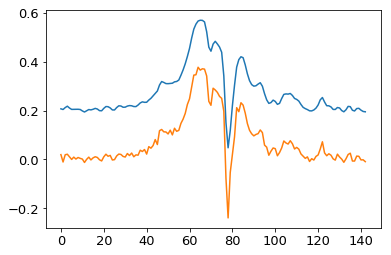

In [158]:
from astropy.convolution import Gaussian1DKernel

cube = SpectralCube.read('field09.fits')
vleft = -30*u.km/u.s
vright = 30*u.km/u.s
cube = cube.spectral_slab(vleft,vright)
kernel=Box1DKernel(2.5)
new_cube = cube.spectral_smooth(kernel)

plt.plot(new_cube.mean(axis=(1,2)).value+0.2)
plt.plot(cube.mean(axis=(1,2)).value)
plt.show()



Set OBSGEO-B to    19.822919 from OBSGEO-[XYZ].
Set OBSGEO-H to     4117.025 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


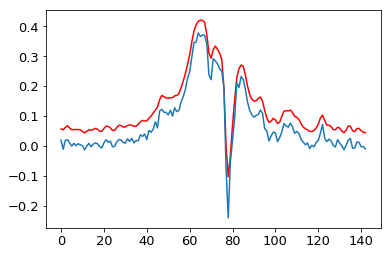

In [162]:
plt.plot(new_cube.mean(axis=(1,2)).value+0.05,'red')
plt.plot(cube.mean(axis=(1,2)).value)
plt.show()

In [168]:
fw

7.647682521331511